<a href="https://colab.research.google.com/github/yasmin-reda/Manufacturing-downtime/blob/main/MANUFACTURING%20DOWNTIME.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [ ]:

server = 'DESKTOP-O1F5FCR\SQLEXPRESS'
database ='yousef'
username = ''
password = ''
connection_string = f"mssql+pyodbc://{username}:{password}@{server}/{database}?driver=ODBC+Driver+17+for+SQL+Server"
engine = create_engine(connection_string)

In [ ]:
df = pd.read_excel(r'D:\season\Final project\Datasets\Datasets\Manufacturing Downtime\Manufacturing_Line_Productivity.xlsx',sheet_name='Line productivity')
ds = pd.read_excel(r'D:\season\Final project\Datasets\Datasets\Manufacturing Downtime\Manufacturing_Line_Productivity.xlsx',sheet_name='Products')
da = pd.read_excel(r'D:\season\Final project\Datasets\Datasets\Manufacturing Downtime\Manufacturing_Line_Productivity.xlsx',sheet_name='Downtime factors')
dw = pd.read_excel(r'D:\season\Final project\Datasets\Datasets\Manufacturing Downtime\Manufacturing_Line_Productivity.xlsx',sheet_name='Line downtime')

In [ ]:
df = pd.merge(df,ds,on = 'Product',how = 'left')

In [ ]:
downtime_long = dw.melt(id_vars="Batch", var_name="Factor", value_name="Duration")
downtime_long = downtime_long.dropna()
downtime_long["Factor"] = downtime_long["Factor"].astype(int)
merged = pd.merge(downtime_long, da, on="Factor", how="left")

downtime_long


,Batch,Factor,Duration
38,422111,2,60.0
39,422112,2,20.0
40,422113,2,50.0
44,422117,2,10.0
57,422130,2,20.0
...,...,...,...
432,422125,12,10.0
436,422129,12,15.0
442,422135,12,15.0
448,422141,12,7.0


In [ ]:
df = pd.merge(df,merged,on = 'Batch',how = 'left')
df

,Date,Product,Batch,Operator,Start Time,End Time,Flavor,Size,Min batch time,Factor,Duration,Description,Operator Error
0,2024-08-29,OR-600,422111,Mac,11:50:00,14:05:00,Orange,600 ml,60,2.0,60.0,Batch change,Yes
1,2024-08-29,OR-600,422111,Mac,11:50:00,14:05:00,Orange,600 ml,60,7.0,15.0,Machine failure,No
2,2024-08-29,LE-600,422112,Mac,14:05:00,15:45:00,Lemon lime,600 ml,60,2.0,20.0,Batch change,Yes
3,2024-08-29,LE-600,422112,Mac,14:05:00,15:45:00,Lemon lime,600 ml,60,8.0,20.0,Batch coding error,Yes
4,2024-08-29,LE-600,422113,Mac,15:45:00,17:35:00,Lemon lime,600 ml,60,2.0,50.0,Batch change,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,2024-09-02,CO-2L,422147,Charlie,19:30:00,22:55:00,Cola,2 L,98,4.0,17.0,Inventory shortage,No
60,2024-09-02,CO-2L,422147,Charlie,19:30:00,22:55:00,Cola,2 L,98,6.0,60.0,Machine adjustment,Yes
61,2024-09-02,CO-2L,422147,Charlie,19:30:00,22:55:00,Cola,2 L,98,7.0,30.0,Machine failure,No
62,2024-09-03,CO-2L,422148,Mac,22:55:00,01:05:00,Cola,2 L,98,4.0,25.0,Inventory shortage,No


In [ ]:
df.to_sql('Manufacturing',con=engine,if_exists='replace',index=False,chunksize=1000)

64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            64 non-null     datetime64[ns]
 1   Product         64 non-null     object        
 2   Batch           64 non-null     int64         
 3   Operator        64 non-null     object        
 4   Start Time      64 non-null     object        
 5   End Time        64 non-null     object        
 6   Flavor          64 non-null     object        
 7   Size            64 non-null     object        
 8   Min batch time  64 non-null     int64         
 9   Factor          61 non-null     float64       
 10  Duration        61 non-null     float64       
 11  Description     61 non-null     object        
 12  Operator Error  61 non-null     object        
dtypes: datetime64[ns](1), float64(2), int64(2), object(8)
memory usage: 6.6+ KB


In [ ]:
query ="""WITH
mode_Factor AS (
    SELECT TOP 1 Factor
    FROM Manufacturing
    GROUP BY Factor
    ORDER BY COUNT(*) DESC
),
mode_Duration AS (
    SELECT TOP 1 Duration
    FROM Manufacturing
    GROUP BY Duration
    ORDER BY COUNT(*) DESC
),
mode_Description AS (
    SELECT TOP 1 Description
    FROM Manufacturing
    GROUP BY Description
    ORDER BY COUNT(*) DESC
),
mode_OperatorError AS (
    SELECT TOP 1 OperatorError
    FROM Manufacturing
    GROUP BY OperatorError
    ORDER BY COUNT(*) DESC
)
UPDATE Manufacturing
SET
Factor=  COALESCE(Factor, (SELECT MAX(Factor) FROM mode_Factor)),
Duration=   COALESCE(Duration, (SELECT MAX(Duration) FROM mode_Duration)),
Description=    COALESCE(Description, (SELECT MAX(Description) FROM mode_Description)),
OperatorError=	COALESCE(OperatorError, (SELECT MAX(OperatorError) FROM mode_OperatorError))
WHERE
Factor IS NULL OR Duration IS NULL OR Description IS NULL OR OperatorError IS NULL ;

"""

query2 ="""SELECT *
FROM Manufacturing
ORDER BY Factor ASC;

"""




In [ ]:
df=pd.read_sql(query2,con=engine)
df

,Date,Product,Batch,Operator,Start Time,End Time,Flavor,Size,Min batch time,Factor,Duration,Description,OperatorError
0,2024-08-29,OR-600,422111,Mac,11:50:00,14:05:00,Orange,600 ml,60,2.0,60.0,Batch change,Yes
1,2024-08-29,LE-600,422112,Mac,14:05:00,15:45:00,Lemon lime,600 ml,60,2.0,20.0,Batch change,Yes
2,2024-08-29,LE-600,422113,Mac,15:45:00,17:35:00,Lemon lime,600 ml,60,2.0,50.0,Batch change,Yes
3,2024-08-29,LE-600,422117,Charlie,21:39:00,22:54:00,Lemon lime,600 ml,60,2.0,10.0,Batch change,Yes
4,2024-08-31,CO-600,422130,Dee,07:45:00,09:05:00,Cola,600 ml,60,2.0,20.0,Batch change,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,2024-08-30,CO-600,422129,Charlie,22:14:00,23:29:00,Cola,600 ml,60,12.0,15.0,Other,No
60,2024-08-30,CO-600,422118,Dee,04:05:00,06:05:00,Cola,600 ml,60,12.0,20.0,Other,No
61,2024-09-02,RB-600,422141,Dennis,07:43:00,08:50:00,Root Berry,600 ml,60,12.0,7.0,Other,No
62,2024-08-31,DC-600,422135,Mac,14:45:00,16:30:00,Diet Cola,600 ml,60,12.0,15.0,Other,No


In [ ]:
print("\n Data Info:")
df.info()


 Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            64 non-null     datetime64[ns]
 1   Product         64 non-null     object        
 2   Batch           64 non-null     int64         
 3   Operator        64 non-null     object        
 4   Start Time      64 non-null     object        
 5   End Time        64 non-null     object        
 6   Flavor          64 non-null     object        
 7   Size            64 non-null     object        
 8   Min batch time  64 non-null     int64         
 9   Factor          64 non-null     float64       
 10  Duration        64 non-null     float64       
 11  Description     64 non-null     object        
 12  OperatorError   64 non-null     object        
dtypes: datetime64[ns](1), float64(2), int64(2), object(8)
memory usage: 6.6+ KB


In [ ]:
print("\n Missing Values:")
df.isnull().sum()


 Missing Values:


Date              0
Product           0
Batch             0
Operator          0
Start Time        0
End Time          0
Flavor            0
Size              0
Min batch time    0
Factor            0
Duration          0
Description       0
OperatorError     0
dtype: int64

In [ ]:
df['Size']= df['Size'].replace('2 L','2000 ml')

In [ ]:
df

,Date,Product,Batch,Operator,Start Time,End Time,Flavor,Size,Min batch time,Factor,Duration,Description,OperatorError
0,2024-08-29,OR-600,422111,Mac,11:50:00,14:05:00,Orange,600 ml,60,2.0,60.0,Batch change,Yes
1,2024-08-29,LE-600,422112,Mac,14:05:00,15:45:00,Lemon lime,600 ml,60,2.0,20.0,Batch change,Yes
2,2024-08-29,LE-600,422113,Mac,15:45:00,17:35:00,Lemon lime,600 ml,60,2.0,50.0,Batch change,Yes
3,2024-08-29,LE-600,422117,Charlie,21:39:00,22:54:00,Lemon lime,600 ml,60,2.0,10.0,Batch change,Yes
4,2024-08-31,CO-600,422130,Dee,07:45:00,09:05:00,Cola,600 ml,60,2.0,20.0,Batch change,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,2024-08-30,CO-600,422129,Charlie,22:14:00,23:29:00,Cola,600 ml,60,12.0,15.0,Other,No
60,2024-08-30,CO-600,422118,Dee,04:05:00,06:05:00,Cola,600 ml,60,12.0,20.0,Other,No
61,2024-09-02,RB-600,422141,Dennis,07:43:00,08:50:00,Root Berry,600 ml,60,12.0,7.0,Other,No
62,2024-08-31,DC-600,422135,Mac,14:45:00,16:30:00,Diet Cola,600 ml,60,12.0,15.0,Other,No


In [ ]:
import datetime

def calculate_time_difference(start_time, end_time):

    if isinstance(start_time, datetime.datetime):
        start_time = start_time.time()
    if isinstance(end_time, datetime.datetime):
        end_time = end_time.time()

    start_datetime = datetime.datetime.combine(datetime.date.today(), start_time)
    end_datetime = datetime.datetime.combine(datetime.date.today(), end_time)

    if end_time < start_time:
        end_datetime += datetime.timedelta(days=1)

    time_difference = end_datetime - start_datetime
    return time_difference.total_seconds() / 3600

df['Hour'] = df.apply(lambda row: calculate_time_difference(row['Start Time'], row['End Time']), axis=1)

In [ ]:
df.to_sql('Manufacturing',con=engine,if_exists='replace',index=False,chunksize=1000)

64

In [ ]:
query= """SELECT TOP 1
    Operator,
    SUM([Duration]) AS TotalDowntime
FROM
    Manufacturing
GROUP BY
    Operator
ORDER BY
    TotalDowntime DESC;"""

In [ ]:
dn=pd.read_sql(query,con=engine)
dn

,Operator,TotalDowntime
0,Charlie,404.0


In [ ]:
dn.to_sql('Top Operator',con=engine,if_exists='replace',index=False,chunksize=1000)

1

In [ ]:
import matplotlib.pyplot as plt

# What is the total downtime per day?

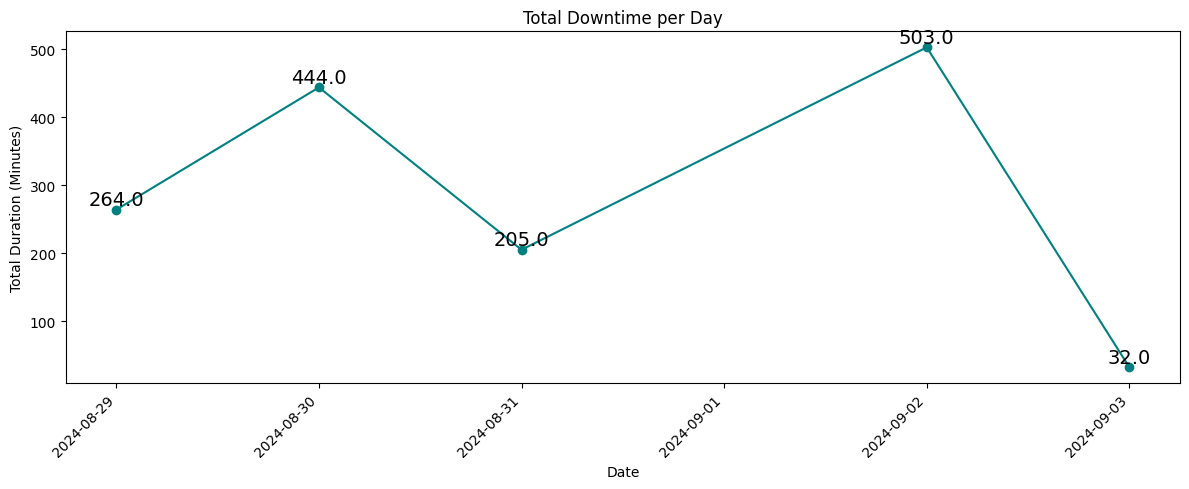

In [ ]:
import matplotlib.pyplot as plt

daily_downtime = df.groupby('Date')['Duration'].sum()

plt.figure(figsize=(12,5))
ax = daily_downtime.plot(kind='line', marker='o', color='teal')

for i, value in enumerate(daily_downtime.values):
    ax.text(daily_downtime.index[i], value + 1, str(round(value, 2)),
            ha='center', va='bottom', fontsize=14)

plt.title("Total Downtime per Day")
plt.xlabel("Date")
plt.ylabel("Total Duration (Minutes)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Benefit: Helps identify specific days with high downtime, which allows managers to investigate what went wrong and prevent future recurrence.


# Which product has the highest average downtime?

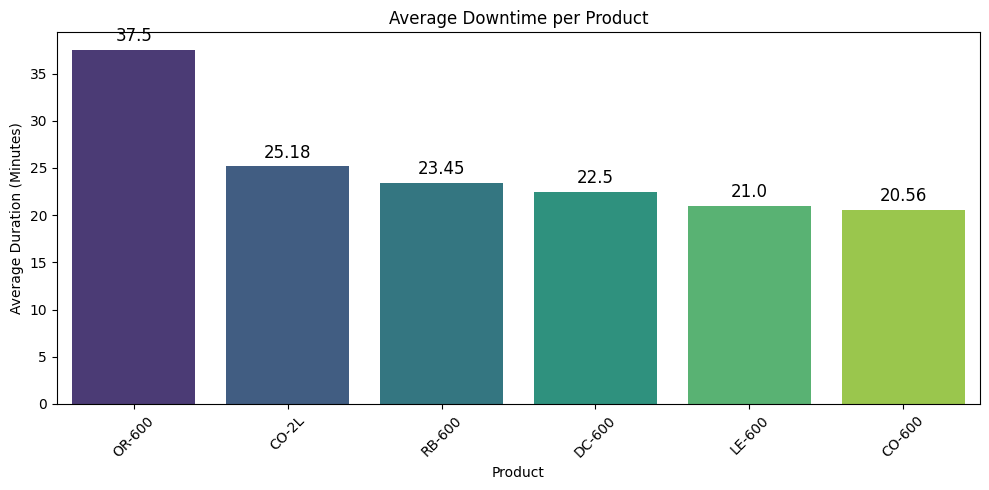

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

product_avg_downtime = df.groupby('Product')['Duration'].mean().sort_values(ascending=False)

plt.figure(figsize=(10,5))
ax = sns.barplot(x=product_avg_downtime.index, y=product_avg_downtime.values, palette='viridis')

for i, value in enumerate(product_avg_downtime.values):
    ax.text(i, value + 0.5, str(round(value, 2)), ha='center', va='bottom', fontsize=12)

plt.title("Average Downtime per Product")
plt.xlabel("Product")
plt.ylabel("Average Duration (Minutes)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Benefit: Identifies the worst-case scenario to understand its cause and make decisions to reduce such extreme cases in the future.

# Which batch has the longest duration?

In [ ]:
longest_batch = df.loc[df['Duration'].idxmax()]
longest_batch

Date              2024-08-29 00:00:00
Product                        OR-600
Batch                          422111
Operator                          Mac
Start Time                   11:50:00
End Time                     14:05:00
Flavor                         Orange
Size                           600 ml
Min batch time                     60
Factor                            2.0
Duration                         60.0
Description              Batch change
OperatorError                     Yes
Hour                             2.25
Name: 0, dtype: object

Benefit: Identifies the worst-case scenario to understand its cause and make decisions to reduce such extreme cases in the future.

# Top 10 Longest Duration Batches

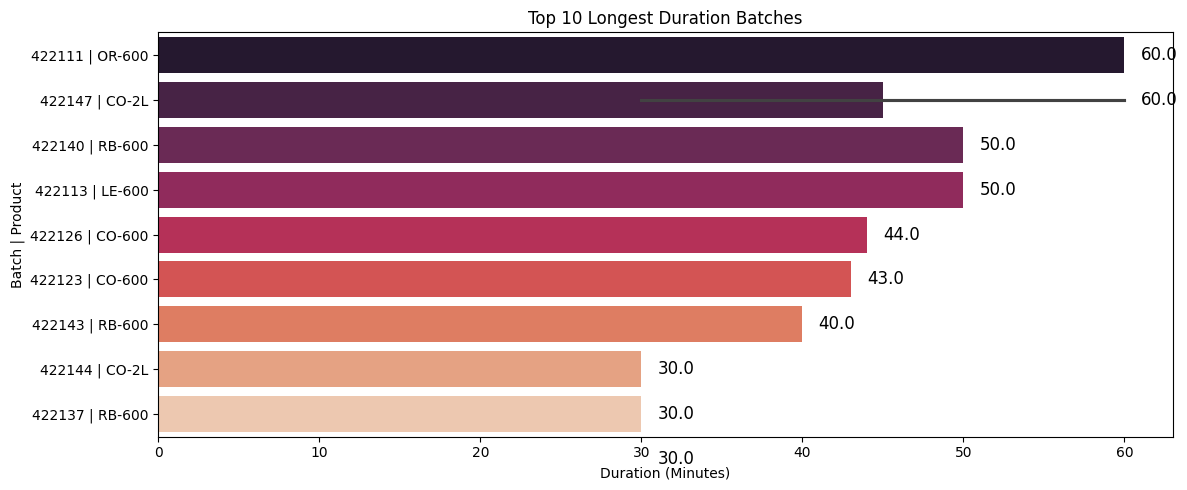

In [ ]:
top_batches = df.sort_values(by='Duration', ascending=False).head(10)

top_batches['Batch_Label'] = top_batches['Batch'].astype(str) + ' | ' + top_batches['Product'].astype(str)

plt.figure(figsize=(12,5))
ax = sns.barplot(x=top_batches['Duration'], y=top_batches['Batch_Label'], palette='rocket')

for i, value in enumerate(top_batches['Duration']):
    ax.text(value + 1, i, str(round(value, 2)), va='center', fontsize=12)

plt.title("Top 10 Longest Duration Batches")
plt.xlabel("Duration (Minutes)")
plt.ylabel("Batch | Product")
plt.tight_layout()
plt.show()


Benefit:
This chart highlights the batches with the longest downtime, helping you identify and address the most significant delays. By focusing on these batches, you can pinpoint the root causes—whether it's related to specific products, equipment issues, or operational inefficiencies—and take targeted actions to minimize downtime and improve overall productivity.


# What are the top reasons for downtime?

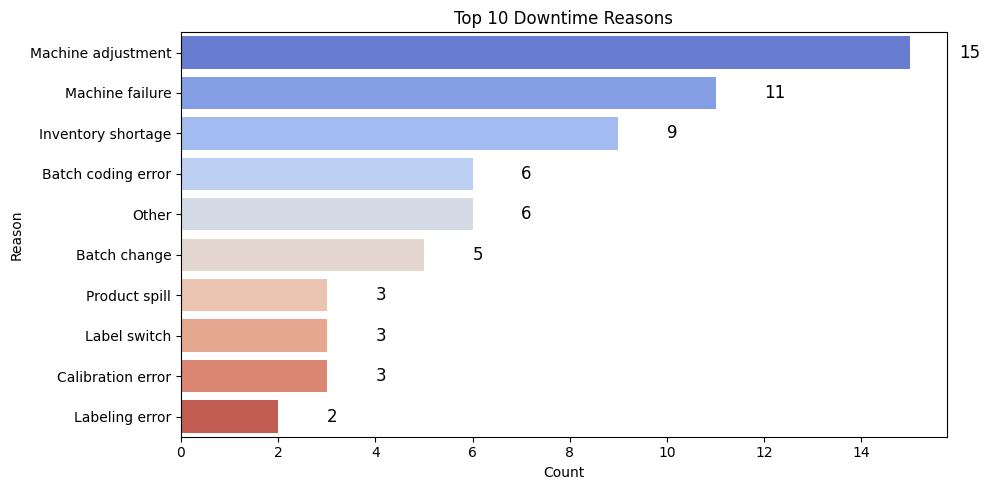

In [ ]:
top_reasons = df['Description'].value_counts().head(10)

plt.figure(figsize=(10,5))
ax = sns.barplot(x=top_reasons.values, y=top_reasons.index, palette='coolwarm')

for i, value in enumerate(top_reasons.values):
    ax.text(value + 1, i, str(value), va='center', fontsize=12)

plt.title("Top 10 Downtime Reasons")
plt.xlabel("Count")
plt.ylabel("Reason")
plt.tight_layout()
plt.show()


Benefit: Reveals the most common causes of downtime, helping the operations team to implement focused solutions or preventive maintenance.


# Do operators differ in average downtime?

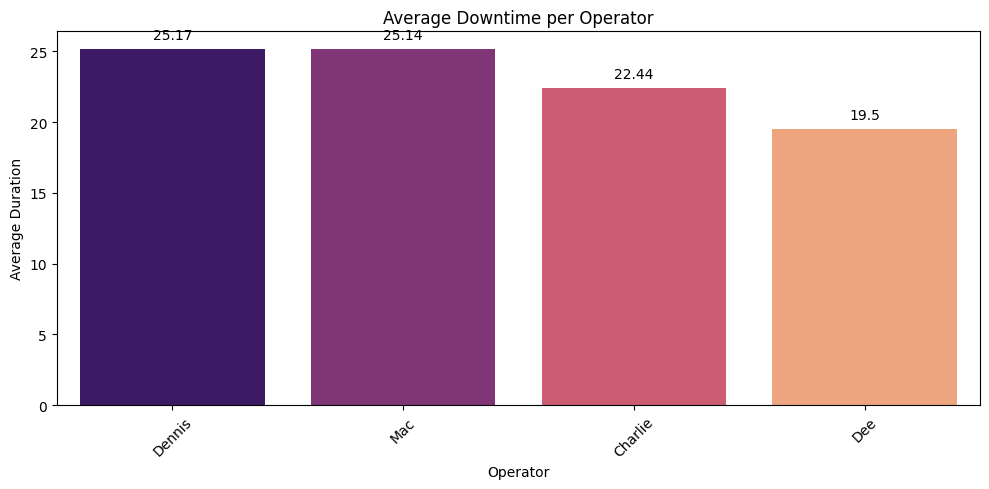

In [ ]:
operator_avg = df.groupby('Operator')['Duration'].mean().sort_values(ascending=False)

plt.figure(figsize=(10,5))
ax = sns.barplot(x=operator_avg.index, y=operator_avg.values, palette='magma')

for i, value in enumerate(operator_avg.values):
    ax.text(i, value + 0.5, str(round(value, 2)), ha='center', va='bottom', fontsize=10)

plt.title("Average Downtime per Operator")
plt.xlabel("Operator")
plt.ylabel("Average Duration")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Benefit: Shows whether certain operators contribute more to downtime, enabling training, support, or performance feedback as needed.


# What percentage of downtime is due to operator error?

In [ ]:
total_duration = df['Duration'].sum()
operator_error_duration = df[df['OperatorError'] == 'Yes']['Duration'].sum()
percentage = (operator_error_duration / total_duration) * 100
print(f"Operator error accounts for {percentage:.2f}% of total downtime.")

Operator error accounts for 57.73% of total downtime.


Benefit : Measures the impact of human errors and highlights training needs.


# Which combination of operator and product causes the most downtime?

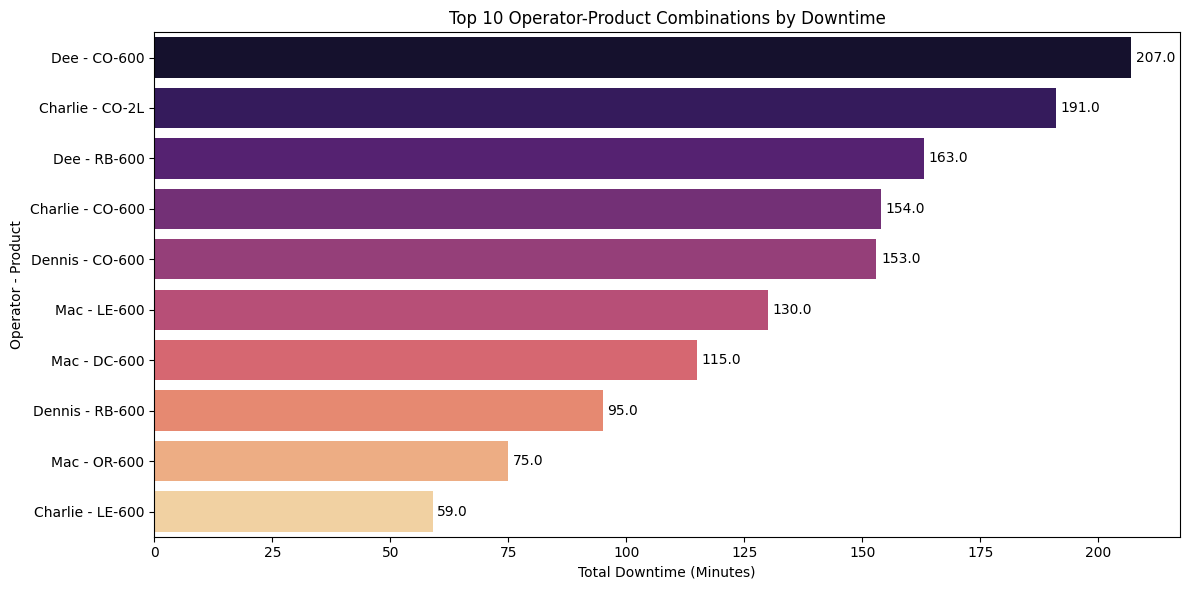

In [ ]:
q7 = df.groupby(['Operator', 'Product'])['Duration'].sum().reset_index()
top7 = q7.sort_values(by='Duration', ascending=False).head(10)

top7['Label'] = top7['Operator'] + ' - ' + top7['Product']

plt.figure(figsize=(12,6))
ax = sns.barplot(data=top7, x='Duration', y='Label', palette='magma')

for i, value in enumerate(top7['Duration']):
    ax.text(value + 1, i, str(round(value, 2)), va='center', fontsize=10)

plt.title("Top 10 Operator-Product Combinations by Downtime")
plt.xlabel("Total Downtime (Minutes)")
plt.ylabel("Operator - Product")
plt.tight_layout()
plt.show()


Benefit : Pinpoints specific operator-product issues for targeted interventions.

# Which flavors or sizes contribute most to downtime?

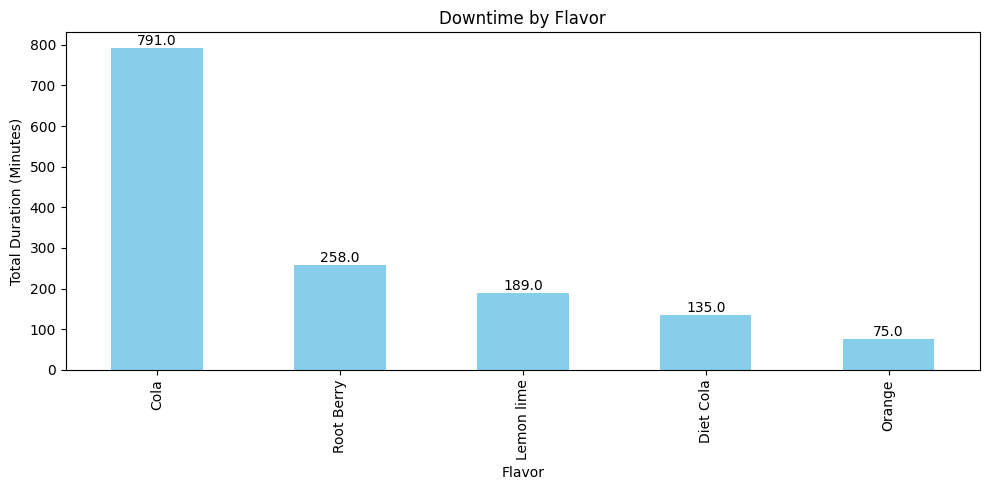

In [ ]:
q10_flavor = df.groupby('Flavor')['Duration'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,5))
ax1 = q10_flavor.plot(kind='bar', color='skyblue', title='Downtime by Flavor')
plt.ylabel('Total Duration (Minutes)')

for i, value in enumerate(q10_flavor.values):
    ax1.text(i, value + 1, str(round(value, 2)), ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()



Benefit : Identifying the flavors or product configurations that contribute the most downtime can help to target process adjustments, redesigns, or improvements specific to those flavors.


In [ ]:
df.to_excel(r'D:\season\Final project\Datasets\Datasets\Manufacturing Downtime\New folder.xlsx',index = False)

# Machine Learning Model

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_excel(r'D:\season\Final project\Datasets\Datasets\Manufacturing Downtime\New folder.xlsx')

In [ ]:
df

,Date,Product,Batch,Operator,Start Time,End Time,Flavor,Size,Min batch time,Factor,Duration,Description,OperatorError,Hour
0,2024-08-29,OR-600,422111,Mac,11:50:00,14:05:00,Orange,600 ml,60,2,60,Batch change,Yes,2.250000
1,2024-08-29,LE-600,422112,Mac,14:05:00,15:45:00,Lemon lime,600 ml,60,2,20,Batch change,Yes,1.666667
2,2024-08-29,LE-600,422113,Mac,15:45:00,17:35:00,Lemon lime,600 ml,60,2,50,Batch change,Yes,1.833333
3,2024-08-29,LE-600,422117,Charlie,21:39:00,22:54:00,Lemon lime,600 ml,60,2,10,Batch change,Yes,1.250000
4,2024-08-31,CO-600,422130,Dee,07:45:00,09:05:00,Cola,600 ml,60,2,20,Batch change,Yes,1.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,2024-08-30,CO-600,422129,Charlie,22:14:00,23:29:00,Cola,600 ml,60,12,15,Other,No,1.250000
60,2024-08-30,CO-600,422118,Dee,04:05:00,06:05:00,Cola,600 ml,60,12,20,Other,No,2.000000
61,2024-09-02,RB-600,422141,Dennis,07:43:00,08:50:00,Root Berry,600 ml,60,12,7,Other,No,1.116667
62,2024-08-31,DC-600,422135,Mac,14:45:00,16:30:00,Diet Cola,600 ml,60,12,15,Other,No,1.750000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            64 non-null     datetime64[ns]
 1   Product         64 non-null     object        
 2   Batch           64 non-null     int64         
 3   Operator        64 non-null     object        
 4   Start Time      64 non-null     object        
 5   End Time        64 non-null     object        
 6   Flavor          64 non-null     object        
 7   Size            64 non-null     object        
 8   Min batch time  64 non-null     int64         
 9   Factor          64 non-null     int64         
 10  Duration        64 non-null     int64         
 11  Description     64 non-null     object        
 12  OperatorError   64 non-null     object        
 13  Hour            64 non-null     float64       
dtypes: datetime64[ns](1), float64(1), int64(4), object(8)
memory

In [ ]:
df.isnull().sum()

Date              0
Product           0
Batch             0
Operator          0
Start Time        0
End Time          0
Flavor            0
Size              0
Min batch time    0
Factor            0
Duration          0
Description       0
OperatorError     0
Hour              0
dtype: int64

In [ ]:
# Convert time columns to datetime and calculate duration
df['Start Time'] = pd.to_datetime(df['Start Time'])
df['End Time'] = pd.to_datetime(df['End Time'])
df['Duration'] = (df['End Time'] - df['Start Time']).dt.total_seconds() / 60

# Select features and target




In [ ]:
features = ['Hour', 'Factor', 'Min batch time']
X = df[features]
y = df['Duration']


# Split data


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Initialize model


In [ ]:

xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
}

grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f"Best Parameters: {grid_search.best_params_}")

best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
accuracy = r2 * 100

print(f"Optimized Mean Squared Error: {mse:.2f}")
print(f"Optimized R² Score: {r2:.2f}")
print(f"Optimized Accuracy: {accuracy:.2f}%")

cv_scores = cross_val_score(best_model, X, y, cv=5, scoring='neg_mean_squared_error')
print(f"Cross-validated Mean Squared Error: {-cv_scores.mean():.2f}")




Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 300, 'subsample': 1.0}
Optimized Mean Squared Error: 31.40
Optimized R² Score: 0.97
Optimized Accuracy: 97.45%
Cross-validated Mean Squared Error: 4574.63


# Visualization


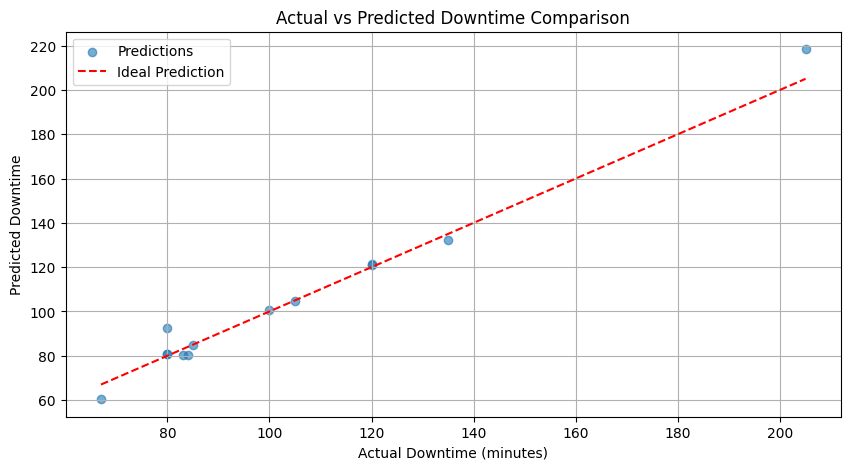

In [ ]:
plt.figure(figsize=(10, 5))
plt.scatter(y_test, predictions, alpha=0.6, label='Predictions')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Ideal Prediction')
plt.xlabel("Actual Downtime (minutes)")
plt.ylabel("Predicted Downtime")
plt.title("Actual vs Predicted Downtime Comparison")
plt.legend()
plt.grid(True)
plt.show()

